## 1. Install the required packages

In [2]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Import the required libraries

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
# cifar10 dataset
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 3. DATA PREPROCESSING

### 3.1 Load the data

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# X represents the images, and y represents the labels

In [5]:
# Check if the data is loaded correctly
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


### 3.2 Normalize the data

In [6]:
# The images in X_train and X_test are initially loaded as integers (uint8), with pixel values ranging from 0 to 255.
#  convert the images to float32 - this is the datatype that the model expects.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0

### 3.3 Split the data into training and testing sets

In [7]:

from sklearn.model_selection import train_test_split
# 20% of the training data will be used for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
# check the shape of the data
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(40000, 32, 32, 3)
(40000, 1)
(10000, 32, 32, 3)
(10000, 1)


### 3.4 Reshape the data to fit the model input

In [9]:
# Convert the labels to one-hot encoding
# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=10)  # For CIFAR-10
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [10]:
# test the new data:
print(y_train.shape)
print(y_test.shape)


(40000, 10)
(10000, 10)


### 3.5 Get the stats of the data

In [11]:
# get how many images are there for each class
def display_stats(arr):
    for i in range(10):
        print(f'{i}: {np.sum(arr == i)}')


# test the function
display_stats(np.argmax(y_train, axis=1))

0: 4027
1: 4021
2: 3970
3: 3977
4: 4067
5: 3985
6: 4004
7: 4006
8: 3983
9: 3960


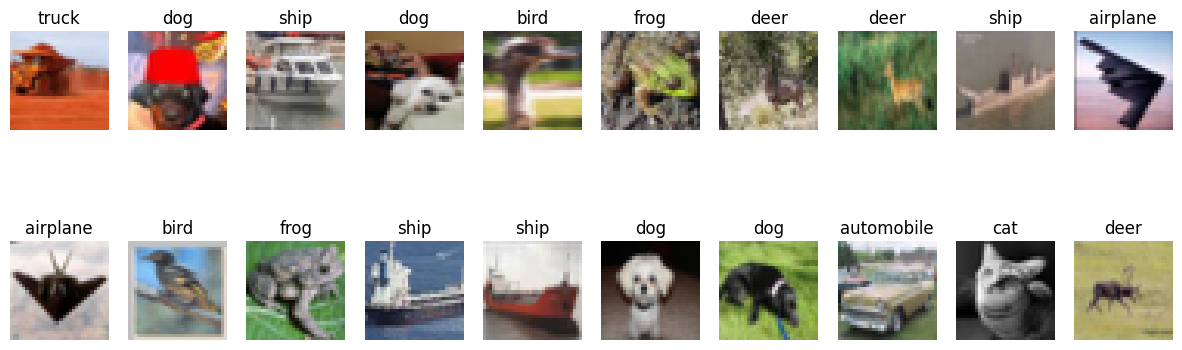

In [12]:
## Get all the labels
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## display the first 20 random images from the training set with their labels names
fig, axes = plt.subplots(2, 10, figsize=(15, 5))
axes = axes.flatten()
for i in range(20):
    # Get a random index from 0 to the length of the training set
    idx = np.random.randint(0, X_train.shape[0])

    # Display image
    axes[i].imshow(X_train[idx])
    # Get the image label and set it as the title
    image_label = y_train[idx].argmax()
    label_name = labels[image_label]
    axes[i].set_title(label_name)
    # Get the label name from the label list
    
    axes[i].axis('off')
plt.show()


## 4. BUILD THE MODEL

### 4.1 Define the model

In [13]:
model = Sequential()

INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10


# Input layer
model.add(Input(shape=INPUT_SHAPE))


# Flatten the input (32x32x3 -> 3072)
model.add(Flatten())


# Hidden layers
model.add(Dense(512, activation='relu'))
# Drop the 30 % of the least important neurons
model.add(Dropout(0.3))  # Dropout for regularization


model.add(Dense(256, activation='relu'))
# Drop the 30 % of the least important neurons
model.add(Dropout(0.3))



model.add(Dense(128, activation='relu'))
# Drop the 30 % of the least important neurons
model.add(Dropout(0.3))


# Output layer (10 classes)
model.add(Dense(NUM_CLASSES, activation='softmax'))


### 4.2 Compile the model

In [14]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

### 4.3 Model Summary

In [15]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,890 (6.63 MB)

 Trainable params: 1,738,890 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

### 4.4 Train the model

In [16]:
EPOCHS = 50
BATCH_SIZE = 64


# Training
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,validation_data=(X_val, y_val))


Epoch 1/50


### 4.5 Evaluate the model

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4077 - loss: 1.6734
Test accuracy: 0.3977999985218048


In [ ]:
### Plotting the training and validation loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


NameError: name 'plt' is not defined